In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
from implementations import *
import os
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'train.csv'
data_path = os.path.join(data_base_path, data_folder)
y, tX, ids = load_csv_data(data_path)

### Change later : Simple data description 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [3]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

y shape = (250000,)
tX shape =(250000, 30)
ids shape = (250000,)


## Changing cv

In [4]:
def standardize_train(x):
    
    mean_x = np.mean(x, axis = 0)
    std_x = np.std(x, axis = 0)
    
    std_x = np.where(std_x == 0, 1, std_x)
    
    x = x - mean_x
    
    x = x / std_x
        
    return x, mean_x, std_x

def standardize_test(x, tr_mean, tr_std):
    
    x = x - tr_mean

    x = x / tr_std
    return x

def standardize_both(x_train, x_test):
    
    std_train_x, mean_x, std_x = standardize_train(x_train)
    std_test_x = standardize_test(x_test, mean_x, std_x)
    
    return std_train_x, std_test_x

In [5]:
def cross_validation_wAcc(y, x, k_indices, k_fold, degrees, lambdas = [0], ml_function = 'ls', max_iters = 0, gamma = 0.05, verbose = False):
    """ Returns a list the train losses and test losses of the cross validation."""

    losses_tr_cv = np.empty((len(lambdas), len(degrees)))
    losses_te_cv = np.empty((len(lambdas), len(degrees)))
    acc_tr_cv = np.empty((len(lambdas), len(degrees)))
    acc_te_cv = np.empty((len(lambdas), len(degrees)))

    for index_lambda, lambda_ in enumerate(lambdas):
        for index_degree, degree in enumerate(degrees):
            losses_tr = np.empty(k_fold)
            losses_te = np.empty(k_fold)
            accuracies_tr = np.empty(k_fold)
            accuracies_te = np.empty(k_fold)
            for k in range(k_fold):
                loss_tr = 0
                loss_te = 0
                te_indices = k_indices[k]
                tr_indices = [ind for split in k_indices for ind in split if ind not in te_indices]
                
                x_tr = x[tr_indices, :].copy()
                x_te = x[te_indices, :].copy()
                
                x_tr, x_te = standardize_both(x_tr, x_te)
                
                
                y_tr = y[tr_indices]
                y_te = y[te_indices]

                tx_tr = build_poly(x_tr, np.int(degree))
                tx_te = build_poly(x_te, np.int(degree))
                

                if ml_function == 'gd':
                    initial_w = np.zeros(tx_tr.shape[1])
                    w_tr, loss_tr = least_squares_GD(y_tr, tx_tr, initial_w, max_iters, gamma)
                    loss_te = compute_mse(y_te, tx_te, w_tr)

                if ml_function == 'sgd' :
                    initial_w = np.zeros(tx_tr.shape[1])
                    w_tr, loss_tr = least_squares_SGD(y_tr, tx_tr, initial_w, max_iters, gamma)
                    loss_te = compute_mse(y_te, tx_te, w_tr)

                if ml_function == 'ri':
                    w_tr, loss_tr = ridge_regression(y_tr, tx_tr, lambda_)
                    loss_te = compute_mse(y_te, tx_te, w_tr)
                    
                #print("After ridge")

                if ml_function == 'lr':
                    initial_w = np.zeros(tx_tr.shape[1])
                    w_tr, loss_tr = logistic_regression(y_tr, tx_tr, initial_w, max_iters, gamma)
                    loss_te = compute_loglikelihood(y_te, tx_te, w_tr)

                if ml_function == 'rlr':
                    initial_w = np.zeros(tx_tr.shape[1])
                    w_tr, loss_tr = reg_logistic_regression(y_tr, tx_tr, lambda_, initial_w, max_iters, gamma)
                    loss_te = compute_loglikelihood(y_te, tx_te, w_tr)

                losses_tr[k] = loss_tr
                losses_te[k] = loss_te
                
                
                if np.isnan(w_tr).any():
                    print(np.sum(np.isnan(w_tr), axis = 0)/w_tr.shape[0], " weights are nan \n")
                
                if ml_function == 'lr' or ml_function == 'rlr':
                    y_tr_pred = our_predict_labels(w_tr, tx_tr, True)
                    y_te_pred = our_predict_labels(w_tr, tx_te, True)
                else:
                    y_tr_pred = our_predict_labels(w_tr, tx_tr)
                    y_te_pred = our_predict_labels(w_tr, tx_te)
                    
                
                
                accuracies_tr[k], _, _, _ = compute_accuracy_measures(y_tr, y_tr_pred)
                accuracies_te[k], _, _, _ = compute_accuracy_measures(y_te, y_te_pred)


            if ml_function == 'gd' or 'sgd' or 'ri':
                losses_tr_cv[index_lambda][index_degree] = np.mean(np.sqrt(2*losses_tr))
                losses_te_cv[index_lambda][index_degree] = np.mean(np.sqrt(2*losses_te))

            if ml_function == 'lr' or 'rlr':
                losses_tr_cv[index_lambda][index_degree] = np.mean(losses_tr)
                losses_te_cv[index_lambda][index_degree] = np.mean(losses_te)
                
            acc_tr_cv[index_lambda][index_degree] = np.mean(accuracies_tr)
            acc_te_cv[index_lambda][index_degree] = np.mean(accuracies_te)
            
            if verbose == True:
                print('Completed degree '+str(degree)+'/'+str(len(degrees)),end="\r",flush=True)

        if verbose == True:
            print('\n Completed lambda '+str(index_lambda+1)+'/'+str(len(lambdas)) + '\n',end="\r",flush=True)

    return losses_tr_cv, losses_te_cv, acc_tr_cv, acc_te_cv


In [6]:
# remove categorical data
tX = np.delete(tX, 22, axis=1)
# keep only columns that do not have too much missing data
tX, rmX = train_data_formatting(tX, degree = 1, cutoff = 0.1, 
                      imputation = impute_median, interaction = False)
# standarize the data
rmX = np.append(rmX, 22)
#tX = np.apply_along_axis(standardize, 1, tX)
print(tX.shape)
print(rmX)
print(y.shape)

(250000, 19)
[ 0  4  5  6 12 22 23 24 25 26 27 22]
(250000,)


In [17]:
seed = 1
degree_ri = 1
k_fold = 4
lambdas = np.logspace(-12, 0, 5)
degrees = range(1, 5)

k_indices = build_k_indices(y[0:10000,], k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_tr_ri, acc_te_ri = cross_validation_wAcc(y[0:10000,], tX[0:10000,:], k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'rlr', max_iters = 100, 
                                          gamma = 0.05, verbose = True)

Completed degree 4/4
 Completed lambda 1/5
Completed degree 4/4
 Completed lambda 2/5
Completed degree 4/4
 Completed lambda 3/5
Completed degree 4/4
 Completed lambda 4/5
Completed degree 4/4
 Completed lambda 5/5


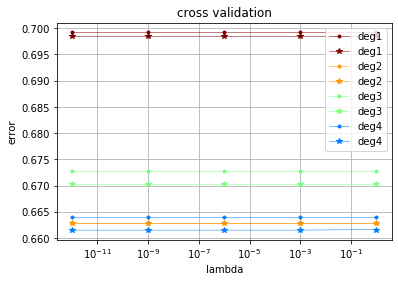

In [18]:
cross_validation_visualization(degrees, acc_tr_ri, acc_te_ri, lambdas)

In [19]:
idx = np.unravel_index(np.nanargmax(acc_te_ri), acc_te_ri.shape)
lambda_ri = lambdas[idx[0]]
degree_ri = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nacc train={acc_tr}\n\nacc test={acc_te} \n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    lambda_=lambda_ri, degree=degree_ri, acc_tr=acc_tr_ri[idx], acc_te=acc_te_ri[idx], rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx]))

lambda*=1e-12

degree*=1

acc train=0.6992

acc test=0.6986 

rmse train=nan

rmse test=nan


In [ ]:
cross_validation_visualization(degrees, rmse_tr_ri, rmse_te_ri, lambdas)

In [ ]:
idx = np.unravel_index(np.nanargmin(rmse_te_ri), rmse_te_ri.shape)
lambda_ri = lambdas[idx[0]]
degree_ri = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nacc train={acc_tr}\n\nacc test={acc_te} \n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    lambda_=lambda_ri, degree=degree_ri, acc_tr=acc_tr_ri[idx], acc_te=acc_te_ri[idx], rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx]))

## Do your thing crazy machine learning thing here :) ...

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)